# import and installation

In [1]:
# library for load and display data
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import shutil
# tansorflow libraries
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
list_data = pd.read_csv("/kaggle/input/list-of-cat/list.csv")

In [3]:
list_data = list_data.drop(columns=["Unnamed: 0"])

In [4]:
cat_data = list_data[list_data["cat_or_dog"]==1]

In [5]:
cat_data["breed_name"] = cat_data["name"].apply(lambda x : str(x).split("_")[0])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
cat_data["breed_name"].unique()

array(['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British', 'Egyptian',
       'Maine', 'Persian', 'Ragdoll', 'Russian', 'Siamese', 'Sphynx'],
      dtype=object)

In [7]:
cat_data.head()

,name,id,cat_or_dog,breed_class,breed_name
0,Abyssinian_100,1,1,1,Abyssinian
1,Abyssinian_101,1,1,1,Abyssinian
2,Abyssinian_102,1,1,1,Abyssinian
3,Abyssinian_103,1,1,1,Abyssinian
4,Abyssinian_104,1,1,1,Abyssinian


# create folders in kaggle working directory

In [8]:
import shutil
import os

In [9]:
# Define the source and destination directories
src_dir = "/kaggle/input/the-oxfordiiit-pet-dataset/images/images"
dst_dir = "/kaggle/working/Cat_Data"
breeds = list(cat_data["breed_name"].unique())

In [10]:
# Loop through the file list and copy each file to the destination directory
for breed in breeds:
  file_list = list((cat_data[cat_data["breed_name"]==breed]["name"]))
  os.makedirs(os.path.join(dst_dir, breed))
  for file_name in file_list:
      file_name_dir = breed + "/" + file_name
      # Construct the full path to the source and destination files
      src_file = os.path.join(src_dir, file_name + ".jpg")
      dst_file = os.path.join(dst_dir, file_name_dir + ".jpg")
      # Copy the file from the source to the destination directory
      shutil.copy(src_file, dst_file)

# data generator

In [11]:
BATCH_SIZE = 16
EPOCHS = 100
Train_path = "/kaggle/working/Cat_Data/"
breeds = os.listdir(Train_path)
DATA_SIZE = 0
for breed in breeds:
  DATA_SIZE += len(os.listdir(os.path.join(Train_path,breed)))
tf.random.set_seed(42)

image in class Russian


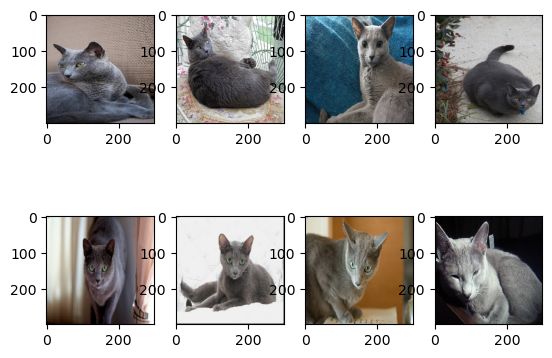

image in class Bombay


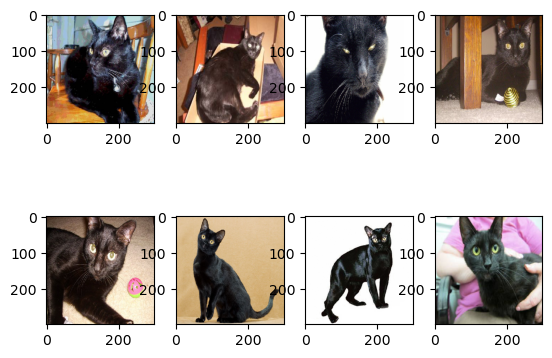

image in class Egyptian


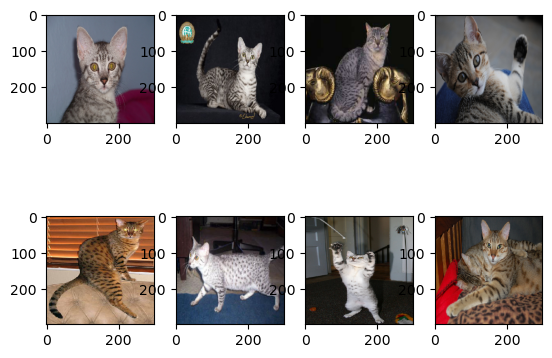

image in class Maine


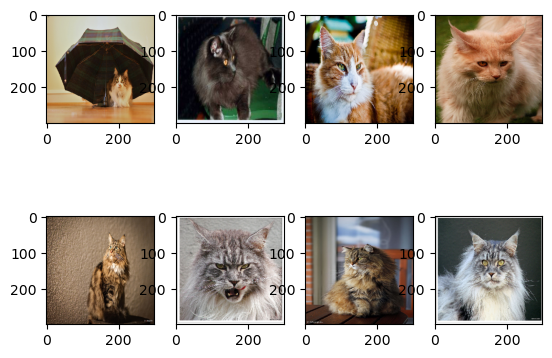

image in class Siamese


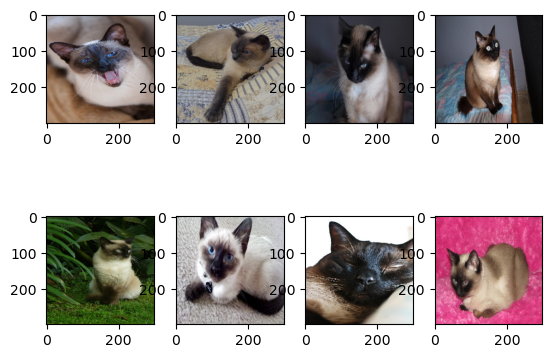

image in class Bengal


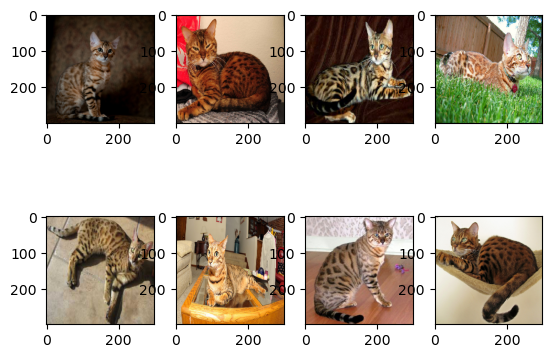

image in class Ragdoll


In [ ]:
for cls in os.listdir(Train_path):
    print(f"image in class {cls}")
    for i,img in enumerate(os.listdir(os.path.join(Train_path , cls ))):
        img=image.load_img(Train_path+cls+"/"+img,target_size=(299,299))
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        if i == 7:
            break
    plt.show()

In [ ]:
# create data generate ==> generate and augment data
data_gene = ImageDataGenerator(rescale = 1./255,
                               rotation_range=20,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               validation_split=0.2,
                               horizontal_flip = True,)

In [ ]:
training_set = data_gene.flow_from_directory(Train_path,
                                             target_size = (299, 299),
                                             batch_size = BATCH_SIZE,
                                             subset='training',
                                             class_mode = 'categorical')

val_set = data_gene.flow_from_directory(Train_path,
                                             target_size = (299, 299),
                                             batch_size = BATCH_SIZE,
                                             subset='validation',
                                             class_mode = 'categorical')

# model Archeticture

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.optimizers import Adam,RMSprop

dropout=.25
learning_rate=0.001

base_model = InceptionV3(weights='imagenet', include_top=False)
base_model.trainable = False


# send results to pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = Flatten()(x)
# send to fully connected layer
x = tf.keras.layers.Dense(256,activation='relu')(x)

# send to dropout layer
x = tf.keras.layers.Dropout(dropout)(x)

# send to batch normalization layer
x = tf.keras.layers.BatchNormalization()(x)
  
# send to output dense layer with SoftMax activation function
outputs = tf.keras.layers.Dense(12,activation='softmax')(x)

# create a model with these layers
model = tf.keras.Model(base_model.inputs, outputs)

# show some information
model.summary()

# compile model with Adam optimizer
# and chosing accuracy as the metric to evaluate the model performance during training
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=learning_rate), metrics=['accuracy'])

In [16]:
# fit the model
early_stop=EarlyStopping(monitor='val_loss',verbose=1,patience=20)
history = model.fit(
                      training_set,
                      validation_data=val_set,
                      epochs=EPOCHS,
                      validation_steps=(DATA_SIZE*0.2)/BATCH_SIZE,
                      steps_per_epoch=(DATA_SIZE*0.8)/BATCH_SIZE,
                      callbacks=[early_stop],
                      batch_size=BATCH_SIZE
                    )

118/118 [==============================] - 53s 444ms/step - loss: 0.5812 - accuracy: 0.8146 - val_loss: 0.4067 - val_accuracy: 0.8686
Epoch 3/100
118/118 [==============================] - 52s 440ms/step - loss: 0.4607 - accuracy: 0.8494 - val_loss: 0.4680 - val_accuracy: 0.8284
Epoch 4/100
118/118 [==============================] - 53s 446ms/step - loss: 0.4129 - accuracy: 0.8747 - val_loss: 0.4364 - val_accuracy: 0.8581
Epoch 5/100
118/118 [==============================] - 52s 442ms/step - loss: 0.3867 - accuracy: 0.8794 - val_loss: 0.4013 - val_accuracy: 0.8644
Epoch 6/100
118/118 [==============================] - 53s 446ms/step - loss: 0.3697 - accuracy: 0.8820 - val_loss: 0.4341 - val_accuracy: 0.8623
Epoch 7/100
118/118 [==============================] - 53s 451ms/step - loss: 0.3272 - accuracy: 0.8973 - val_loss: 0.3778 - val_accuracy: 0.8581
Epoch 8/100
118/118 [==============================] - 52s 443ms/step - loss: 0.3557 - accuracy: 0.8873 - val_loss: 0.3962 - val_accurac

In [17]:
evaluate_val = model.evaluate(val_set, steps=int((DATA_SIZE*0.2)/BATCH_SIZE))
evaluate_train = model.evaluate(training_set, steps=int((DATA_SIZE*0.8)/BATCH_SIZE))

118/118 [==============================] - 42s 352ms/step - loss: 0.1272 - accuracy: 0.9597


#  save run log

In [18]:
def creat_csv(lr, optimizer, history, model, evaluate_val, evaluate_train):
    model_name = optimizer + "_" + str(lr) + ".h5"
    his_df = pd.DataFrame(history.history)
    his_df["learning_rate"] = lr
    his_df["optimizer"] = optimizer
    his_df["model_name"] = model_name
    his_df.to_csv("/kaggle/working/model_5.csv")
    model.save('/kaggle/working/'+ model_name)
    results = {
            "val_loss":[evaluate_val[0]],
            "val_acc":[evaluate_val[1]],
            "train_loss":[evaluate_train[0]],
            "train_acc":[evaluate_train[1]],
            "model_name":[model_name]
          }
    result = pd.DataFrame(results)
    result.to_csv("/kaggle/working/model_res_5.csv")

In [19]:
creat_csv(0.001, "RMSprop", history, model, evaluate_val, evaluate_train)